In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Perform if using David Drive
!cat /content/drive/MyDrive/ComputerVisionWorkshop/

cat: /content/drive/MyDrive/ComputerVisionWorkshop/: No such file or directory


In [ ]:
# Perform if using Hermes Drive
%cd drive/MyDrive/ComputerVisionWorkshop/dataset

/content/drive/MyDrive/ComputerVisionWorkshop/dataset


In [ ]:
!pwd

/content/drive/MyDrive/ComputerVisionWorkshop/dataset


# Welcome to our Computer Vision Workshop

Here's the dataset we'll be using today: [Cats and Dogs](https://www.kaggle.com/chetankv/dogs-cats-images)

In [ ]:
# Necessary Libraries
import sys
from matplotlib import pyplot # plotting
from matplotlib.image import imread
from matplotlib import pyplot
from os import listdir #preprocessing
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical # Model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


## Showing some pictures

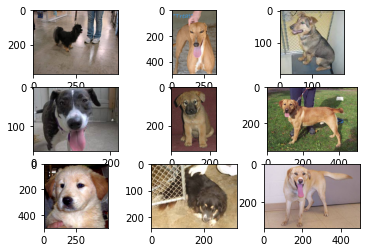

In [ ]:
# Let's get see what we're working with (dog edition)
folder = 'training_set/dogs/'

for i in range(9):
  pyplot.subplot(330 + 1 + i)
  startingNum = 1000 + i
  filename = f"{folder}dog.{str(startingNum)}.jpg" 
  image = imread(filename)
  pyplot.imshow(image)

pyplot.show()


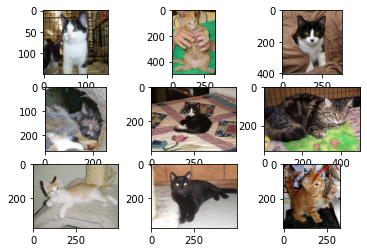

In [ ]:
# Let's get see what we're working with (cat edition) 
folder = 'training_set/cats/'

for i in range(9):
  pyplot.subplot(330 + 1 + i)
  startingNum = 1000 + i
  filename = f"{folder}cat.{str(startingNum)}.jpg" 
  image = imread(filename)
  pyplot.imshow(image)

pyplot.show()


## Preprocessing: Lot of pictures vs. Not a lot of pictures

In [ ]:
# define locations of the dataset
dog_folder = 'training_set/dogs/'
cat_folder = 'training_set/cats/'
photos, labels = list(), list()

def folderToArray(folder):
  # enumerate files in the directory
  for file in listdir(folder):
    # determine output for each class
    output = 0.0
    if file.startswith('cat'):
      output = 1.0
    # load image
    photo = load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)
 
folderToArray(dog_folder)
folderToArray(cat_folder)

# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

## What is a CNN?

![CNN illustration by Hemant Sawant](https://miro.medium.com/max/954/1*b2chz3uIIb9I1qGhuN0crQ.jpeg)

## Creating the CNN model

Reference:
- https://deepai.org/machine-learning-glossary-and-terms/convolutional-neural-network
- https://deepai.org/machine-learning-glossary-and-terms/max-pooling
- https://keras.io/api/layers/core_layers/dense/
- https://keras.io/api/layers/reshaping_layers/flatten/ 
- https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a 

In [ ]:
# Create the model
def define_model1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

## Creating a better CNN model

Reference:
- https://keras.io/api/layers/regularization_layers/dropout/

In [ ]:
# Better CNN model
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

## Visualizing the results

In [ ]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [ ]:
# define model
model = define_model1()
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))

In [ ]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)